# Overview

NYC Subway contains regular number of ridership across different conditions. It also contains time series. In this analysis, I investigate whether there is difference between raining vs not raining, and other statistical method to build the model, predicting number of ridership.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sp
# %matplotlib notebook
%matplotlib inline
import seaborn as sns; sns; sns.set_style('dark')
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('turnstile_data_master_with_weather.csv')
df.index = pd.to_datetime(df.pop('DATEn') +' '+ df.pop('TIMEn'))
df.sort_index(inplace=True)
del df['Unnamed: 0']

In [10]:
df.head()

,UNIT,Hour,DESCn,ENTRIESn_hourly,EXITSn_hourly,maxpressurei,maxdewpti,mindewpti,minpressurei,meandewpti,meanpressurei,fog,rain,meanwindspdi,mintempi,meantempi,maxtempi,precipi,thunder
2011-05-01,R114,0,REGULAR,0,0,30.31,42,35,30.23,39,30.27,0,0,5,50,60,69,0,0
2011-05-01,R123,0,REGULAR,0,0,30.31,42,35,30.23,39,30.27,0,0,5,50,60,69,0,0
2011-05-01,R429,0,REGULAR,0,0,30.31,42,35,30.23,39,30.27,0,0,5,50,60,69,0,0
2011-05-01,R081,0,REGULAR,0,0,30.31,42,35,30.23,39,30.27,0,0,5,50,60,69,0,0
2011-05-01,R029,0,REGULAR,0,0,30.31,42,35,30.23,39,30.27,0,0,5,50,60,69,0,0


# References

* https://class.coursera.org/statistics-003
* https://www.udacity.com/course/intro-to-data-science--ud359
* http://blog.minitab.com/blog/adventures-in-statistics/multiple-regession-analysis-use-adjusted-r-squared-and-predicted-r-squared-to-include-the-correct-number-of-variables
* https://en.wikipedia.org/wiki/Coefficient_of_determination
* http://napitupulu-jon.appspot.com/posts/inference-diagnostic-mlr-coursera-statistics.html

# Statistical Test

In [6]:
df.groupby('rain',as_index=False).ENTRIESn_hourly.mean()

,rain,ENTRIESn_hourly
0,0,1090.278780
1,1,1105.446377


In this data, we can see summary statistic of number of ridership hourly, represented by `ENTRIESn_hourly` variable  between rainy days and non-rainy days. So the independent variable is `rain` that represented as non-rainy day in control group, and `non-rainy` in experiment group. How rainy days affect the number of ridership, so the dependent variable is `ENTRIESn_hourly`. 

We can see that means of number ridership hourly of non-rainy days is 1090, where the means with rainy days is 1105. Such small difference, and we're going to test whether the difference is significantly higher, using independence test with one-tail p-value. I'm using 0.05 as p-critical value.

* H0 $ P_\mathbf{(rain > non-rain)} = 0.5$ : Population number of ridership in rainy days and non-rainy days is equal.
* HA $ P_\mathbf{(rain > non-rain)} \gt 0.5$ : Population number of ridership in rainy days is higher than non-rainy days.


The conditions within groups have validated. The sample size in this data is more than 30, and less than 10% population.

Non-parametric test used as statistical test that doesn't assume any underlying probability distribution. Mann Whittney U test is one of non-parametric test that I will be using in this case. Since we see that the distribution of both rainy and non-rainy is very right skewed in the Visualization section, we can't use any statistical test that assume normal distribution. So instead we can use non-parametric test.

In [6]:
df.groupby('rain',as_index=False).ENTRIESn_hourly.mean()

,rain,ENTRIESn_hourly
0,0,1090.278780
1,1,1105.446377


In [16]:
sp.mannwhitneyu(df.ix[df.rain==0,'ENTRIESn_hourly'],
             df.ix[df.rain==1,'ENTRIESn_hourly'])

(1924409167.0, 0.024999912793489721)

We're using Mann-Whitney U test with average 1090 hourly ridership on non-rainy days and 1105 hourly ridership on rainy days. Because p-value is 0.025 less than 0.05 p-critical, we reject the null hypothesis, and conclude that the data provide convincing evidence that average number of hourly ridership in rainy days is higher than those of non-rainy days.

# Linear Regression

* OLS using Statsmodels or Scikit Learn
* Gradient descent using Scikit Learn
* Or something different?*

I'm going to use linear regression with multiple predictor, hence multiple linear regression with OLS.

I use all numerical variables in my data plus additional variable isBusinessDay, except exits, since it will be expected that number of ridership between entries and exits will be similar. I use UNIT and Hour as dummy variables. I don't test dummy features, since it's computationally expensive. I also subset the data since it's also computationally expensive learn from dummy features. Moreover I know that UNIT and Hour features improve the model when I try it at the Udacity website. 

In [6]:
length = df.shape[0]
subset = df.take(np.random.permutation(length)[:int(length*0.1)]).reset_index()

dummy_hours = pd.get_dummies(subset['Hour'], prefix='hour')
dummy_units = pd.get_dummies(subset['UNIT'], prefix='unit')

# features = subset.join(dummy_units).join(dummy_hours)
features = subset
banned = ['ENTRIESn_hourly','UNIT','Hour','DESCn','EXITSn_hourly','index']
candidates = [e for e in features.columns if e not in banned]

 R squared is not a significant measures for testing our model. Since every time we're adding a variable, R-squared will keep increasing. We're going to use adjusted R-squared, since it will incorporate penalty everytime we're adding a variable.

In [7]:
def test_adjusted_R_squared(col):
    """Testing one variable with already approved predictors"""
    
    reg = sm.OLS(features['ENTRIESn_hourly'],features[predictors + [col]])
    result = reg.fit()
    return result.rsquared_adj

I'm going to choose forward selection, where I add one variable at a time based on highest adjusted R squared. And I will stop adding a variable if there's isnt anymore increase compared to previous adjusted R squared.

In [8]:
predictors = []
topr2 = 0
for i in xrange(len(candidates)):
    
    filtered = filter(lambda x: x not in predictors, candidates)
    list_r2 = map(test_adjusted_R_squared,filtered)
    highest,curr_topr2 = max(zip(filtered,list_r2),key=lambda x: x[1])
    
    if curr_topr2 > topr2:
        topr2 = round(curr_topr2,10)
    else:
        print("Adjusted R Squared can't go any higher. Stopping")
        break
        
    predictors.append(highest)
    print('Step {}: Adjusted R-squared = {} + {}'.format(i,topr2,highest))

Step 0: Adjusted R-squared = 0.1838127827 + maxpressurei
Step 1: Adjusted R-squared = 0.1932579575 + BusinessDay
Step 2: Adjusted R-squared = 0.1939087238 + mintempi
Step 3: Adjusted R-squared = 0.1939172251 + precipi
Step 4: Adjusted R-squared = 0.194064459 + rain
Adjusted R Squared can't go any higher. Stopping


These are non dummy features after I perform forward selection

In [9]:
predictors

['maxpressurei', 'BusinessDay', 'mintempi', 'precipi', 'rain']

To test collinearity that may happen in my numerical features, I use scatter matrix.

Scatter Matrix of features and predictors to test collinearity


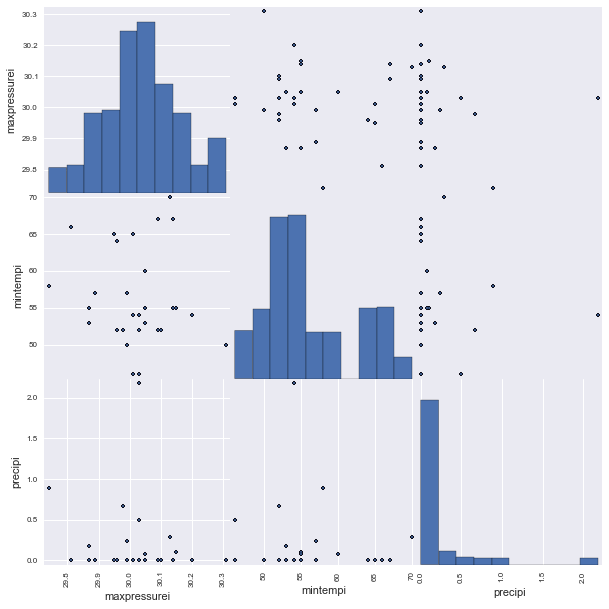

In [176]:
print('Scatter Matrix of features and predictors to test collinearity');
pd.scatter_matrix(features[numerics],figsize=(10,10));

I can see that there are no collinearity among the predictors.

Next I join non-dummy features and dummy features to `features_dummy` and create the model.

In [10]:
features_dummy = features[predictors].join(dummy_units).join(dummy_hours)
model = sm.OLS(features['ENTRIESn_hourly'],features_dummy).fit()

In [11]:
filter_cols = lambda col: not col.startswith('unit') and not col.startswith('hour')
model.params[model.params.index.map(filter_cols)]

maxpressurei   -398.519202
BusinessDay    -547.164804
mintempi         -9.653110
precipi          39.689893
rain           -117.832918
dtype: float64

In [12]:
model.rsquared

0.62666677409655058

*R2 is often interpreted as the proportion of response variation "explained" by the regressors in the model.* So we can say 61.67% of the variability in the % number of ridership subway hourly can be explained by the model.

# Visualization

At the time of this writing, pandas has grown mature, and ggplot for python,which relies on pandas, is not being updated. So I will not use ggplot in this section, and use pandas plotting.

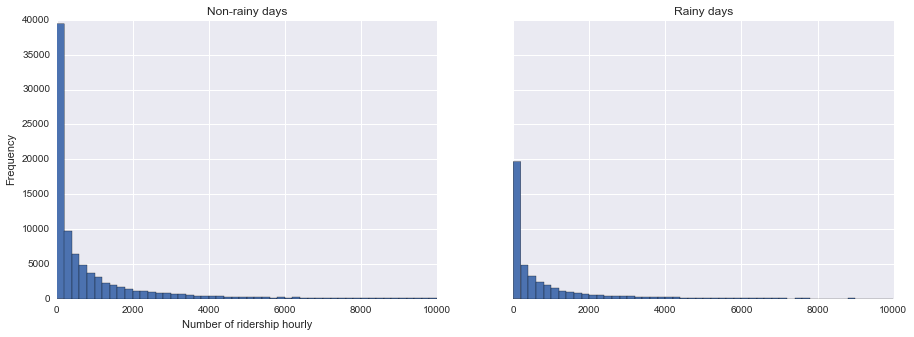

In [92]:
fig,axes = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,squeeze=False)

filtered = df.ix[df.ENTRIESn_hourly < 10000]

for i in xrange(1):
    axes[0][i].set_xlabel('Number of ridership hourly')
    axes[0][i].set_ylabel('Frequency')

filtered.ix[filtered.rain == 0,'ENTRIESn_hourly'].hist(ax=axes[0][0],bins=50)
axes[0][0].set_title('Non-rainy days')
filtered.ix[filtered.rain == 1,'ENTRIESn_hourly'].hist(ax=axes[0][1],bins=50)
axes[0][1].set_title('Rainy days')

fig.set_size_inches((15,5))

In this plot, we can see that more people is riding the subway. But we want to know whether the difference is significance, using hypothesis test. The frequency is indeed higher for non-rainy days compared to non-rainy days.

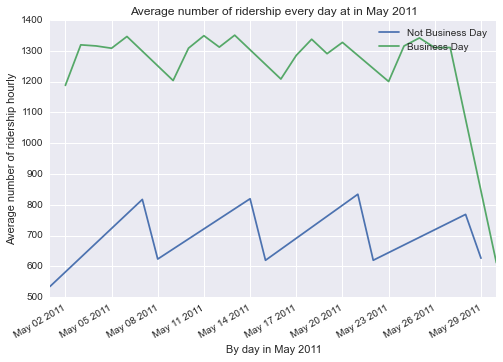

In [96]:
(df
 .resample('1D',how='mean')
 .groupby(lambda x : 1 if pd.datetools.isBusinessDay(x) else 0)
 .ENTRIESn_hourly
 .plot(legend=True))
plt.legend(['Not Business Day', 'Business Day'])
plt.xlabel('By day in May 2011')
plt.ylabel('Average number of ridership hourly')
plt.title('Average number of ridership every day at in May 2011');

We can see that the difference is likely siginificant of ridership from the time of day. We can create a new variable to turn this into categorical variable.

In [5]:
df['BusinessDay'] = df.index.map(lambda x : 0 if pd.datetools.isBusinessDay(x) else 1)

In [153]:
df.resample('1D').rain.value_counts()

0    20
1    10
Name: rain, dtype: int64

# Conclusion

Since the data is observation and not controlled experiment, we can't make causation. However there is likely to be no different for average number of ridership hourly of non-rainy days and rainy days. We know that the dataset is taken from NYC data subway, but because the data is not random sampled in this observation, we can't generalize to all people who use subway in NYC. So pretty much we can't make any causal statement that whether or not there is a difference of average number ridership hourly between rainy days and non rainy days. Moreover, the data also doesn't provide convincing evidence that the number people ride NYC subway is significantly different between rainy days and not rainy days.

Using Statistical Test, If in fact there's no different of average number of ridership hourly of non-rainy days and rainy days, the probability of getting a sample with size 44104 for rainy days and 87847 sample size for non-rainy days with average difference of 15 ridership, is 0.025. Such a small probability could means that rain is a significant predictor, and the difference it's not due to chance.

Using Linear Regression, we can say that all else held constant, the model predicts number of ridership in one hour for non-rainy days is 117 people higher than rainy days, on average.

# Reflection

So where will this lead us? Well we could see that in average day, number of ridership still following some pattern. But it's not clear how this affect through season since we only have limited data. The data itself could expand to through one year. As we can see that this data only include May 2011, and we have no idea how winter, autumn, summer, and spring affecting the number of ridership.

That's more analysis that can be done. With statistical test, I just analyze how rain is not significant different. The different is just due to chance, or it could be other factor than the rain. Fog may be significantly different, or you also that in Visualization section, the number of ridership is different between business day and non business day.

We also have seen that the distribution of number in hour (ENTRIESn_hourly) is right skewed, so we could do some tranformation to make it more normal. The number of ridership between business day and non business day also not linear, it follows what seems to be cyclical.


The model predict not really linear. To test the performance of our model we can do following things:

* linear relationship between every numerical explanatory and response
* Nearly normal residuals wih mean 0
* Constant variability of residuals
* Independent residuals

Our model is not a good fit if at least one this diagnostics failed, which it does.

### linear relationship between every numerical explanatory and response

To test if the model is good we can plot all the numerical features again residuals, see whether every plot is random scatter around zero. This is to check whether there is a linear relationship between residuals and numerical features, to make sure that it doesn't containy any other dependent variables.

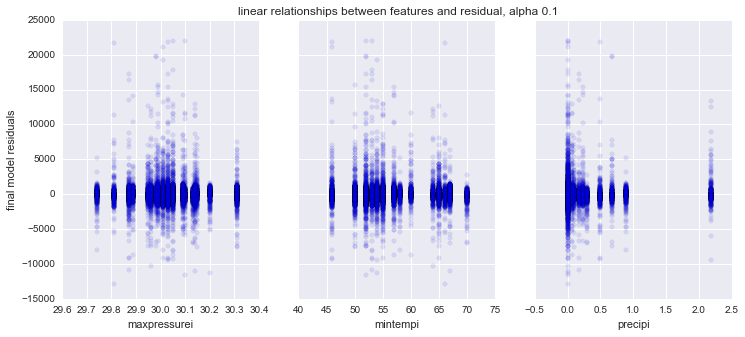

In [150]:
fig,axes = plt.subplots(nrows=1,ncols=3,sharey=True,squeeze=False)
numerics = ['maxpressurei', 'mintempi', 'precipi']
for i in xrange(len(numerics)):
    axes[0][i].scatter(x=features[numerics[i]],y=model.resid,alpha=0.1)
    axes[0][i].set_xlabel(numerics[i])
    

axes[0][0].set_ylabel('final model residuals')
axes[0][1].set_title('linear relationships between features and residual, alpha 0.1')
fig.set_size_inches(12,5);

We see that eventhough seems categorical `maxpressurei` and `mintempi` is random scatter. But `precipi` is not a good candidate for linear relationship of the model. It seems it's not randomly scattered.

### Nearly normal residuals wih mean 0

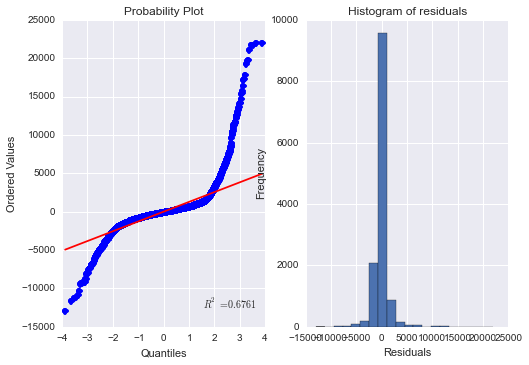

In [145]:
fig,axes = plt.subplots(nrows=1,ncols=2,squeeze=False)

sp.probplot(model.resid,plot=axes[0][0])
model.resid.hist(bins=20,ax=axes[0][1]);

axes[0][1].set_title('Histogram of residuals')
axes[0][1].set_xlabel('Residuals')
axes[0][1].set_ylabel('Frequency');

Next, we're checking by histogram that the residuals is normally distributed. The histogram shown that it's pretty normal and distributed around zero. Quantile plot checking if the residuals randomly scattered around zero. We can see that our model failed in this test. The residuals is very skewed, explained by large number of points deviated from mean line at tails area. This means that our linear regression is not a good model for this case.

### Constant variability of residuals

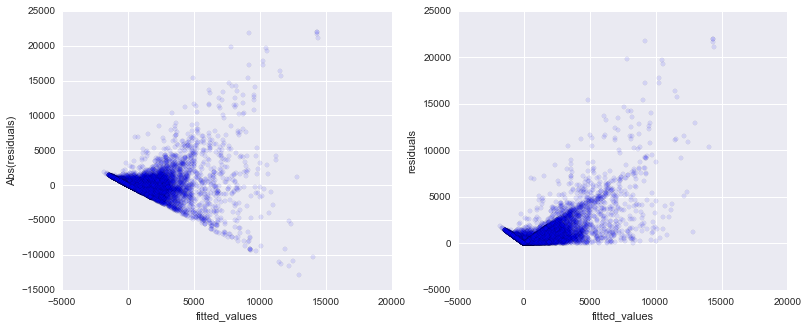

In [154]:
fig,axes = plt.subplots(nrows=1,ncols=2,squeeze=False)
axes[0][0].scatter(x=model.fittedvalues, y=model.resid, alpha=0.1)
axes[0][1].scatter(x=model.fittedvalues, y=abs(model.resid), alpha=0.1);

axes[0][0].set_xlabel('fitted_values')
axes[0][1].set_xlabel('fitted_values')

axes[0][0].set_ylabel('Abs(residuals)')
axes[0][1].set_ylabel('residuals');

fig.set_size_inches(13,5)

The model also failed in this diagnostic. The first plot, the fitted values and residuals should be randomly scattered around zero, and not performing some kind of fan shape. For the plot in the left, we're seeing that there's some kind of boundary that limit the plot to be randomly scattered, and it's performing fan shape. This could means there's another dependent variables that we don't yet find. Some fan shape also ocurring where we plot in the right with absolute value of residuals.

### Independent residuals

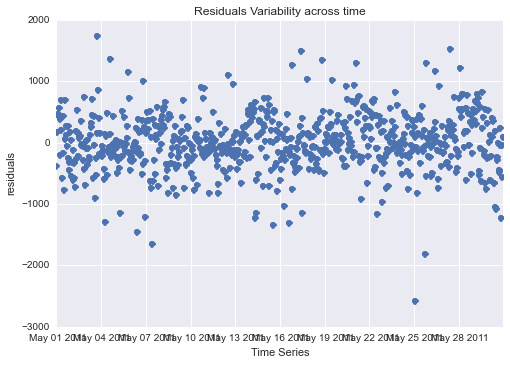

In [107]:
resids = pd.DataFrame(model.resid.copy())
resids.columns = ['residuals']
resids.index = pd.to_datetime(features['index'])
resids.sort_index(inplace=True)

plt.plot_date(x=resids.resample('1H',how='mean').index,
              y=resids.resample('1H',how='mean').residuals);
plt.xlabel('Time Series')
plt.ylabel('residuals')
plt.title('Residuals Variability across time');

Finally, our model should be independent across time. We can plot this by residuals through time series, checking whether the residuals is constant variability, randomly scatter around zero. In this plot, it's pretty constant across May 2011. But since we only have limited data, 1 month and 1 year, we can't be sure whether the model predict accurately in any other month and year.

As linear regression is not a good model, there's could be another model, and some additional dependent variables, that can be used to better fit for this problem.